## Create nodes in Neo4j

In [ ]:
!pip install python-dotenv
!pip install langchain-community
!pip install neo4j
!pip install openai
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml-cu12 25.2.1 requires cupy-cuda12x>=12.0.0, which is not installed.
cudf-cu12 25.2.1 requires cupy-cuda12x>=12.0.0, which is not installed.
dask-cudf-cu12 25.2.2 requires cupy-cuda12x>=12.0.0, which is not installed.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
bigframes 2.4.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [ ]:
# Step 1: Import and Connect to Neo4j
from dotenv import load_dotenv
import os, json
from langchain_community.graphs import Neo4jGraph
from tqdm import tqdm
from google.colab import drive

drive.mount('/content/drive')

from dotenv import load_dotenv
load_dotenv('/content/drive/MyDrive/rag2.env', override=True)

NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_DATABASE = os.getenv("NEO4J_DATABASE")

kg = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    database=NEO4J_DATABASE
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 2: Load cleaned 10-K JSON in bulk
import re
import glob
from langchain.text_splitter import RecursiveCharacterTextSplitter
# 1. Base directory on your mounted Drive
BASE_DIR = "/content/drive/MyDrive/output"
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 2000,
    chunk_overlap  = 200,
    length_function = len,
    is_separator_regex = False,
)

# 2. Collect the latest 10-K JSON for each company
latest_files = []
for company_folder in os.listdir(BASE_DIR):
    folder = os.path.join(BASE_DIR, company_folder)
    if not os.path.isdir(folder):
        continue


    # match files like "AAPL_10k_2024.json" or "JPM_10k_2025.json"
    pattern = os.path.join(folder, "*_10k_*.json")
    candidates = glob.glob(pattern)
    if not candidates:
        continue

    # extract year and pick the file with the highest year
    files_with_year = []
    for fpath in candidates:
        m = re.search(r"_10k_(\d{4})\.json$", fpath)
        if m:
            year = int(m.group(1))
            files_with_year.append((year, fpath))
    if not files_with_year:
        continue

    _, latest = max(files_with_year, key=lambda x: x[0])
    latest_files.append(latest)

print(f" {len(latest_files)}  10-K：")
for path in latest_files:
  print("  ", path)

# 3. Load each latest file and combine the key sections
documents = []
for filepath in latest_files:
    with open(filepath, "r", encoding="utf-8") as f:
        data = json.load(f)

    company = os.path.basename(filepath).split("_")[0]
    year = re.search(r"_10k_(\d{4})\.json$", filepath).group(1)
    # grab metadata fields from the cleaned JSON
    cik     = data.get("cik", "")
    cusip6  = data.get("cusip6", "")
    source  = data.get("source", "")
    sections = {}
    for sec_key in ("item1", "item1a", "item7", "item7a"):
        raw_text = data.get(sec_key, "")
        if not raw_text:
            sections[sec_key] = []
            continue
        chunks = text_splitter.split_text(raw_text)
        # 去除首尾空白
        chunks = [chunk.strip() for chunk in chunks if chunk.strip()]
        sections[sec_key] = chunks

    documents.append({
        "company": company,
        "year":    year,
        "cik":     cik,
        "cusip6":  cusip6,
        "source":  source,
        "sections": sections
    })

# `documents` now holds one entry per company:
# [
#   {"company": "AAPL", "year": "2024", "text": "..."},
#   {"company": "JPM",  "year": "2025", "text": "..."},
#   ...
# ]

 10  10-K：
   /content/drive/MyDrive/output/XOM/XOM_10k_2025.json
   /content/drive/MyDrive/output/PLD/PLD_10k_2025.json
   /content/drive/MyDrive/output/NFLX/NFLX_10k_2025.json
   /content/drive/MyDrive/output/AAPL/AAPL_10k_2024.json
   /content/drive/MyDrive/output/JPM/JPM_10k_2025.json
   /content/drive/MyDrive/output/WMT/WMT_10k_2025.json
   /content/drive/MyDrive/output/BA/BA_10k_2025.json
   /content/drive/MyDrive/output/TSLA/TSLA_10k_2025.json
   /content/drive/MyDrive/output/JNJ/JNJ_10k_2025.json
   /content/drive/MyDrive/output/NVDA/NVDA_10k_2025.json


In [ ]:
# Step 3: Bulk import each company's latest 10-K chunks into Neo4j
for doc in documents:
    company = doc["company"]
    year    = doc["year"]
    cik     = doc.get("cik", "")
    cusip6  = doc.get("cusip6", "")
    source  = doc.get("source", "")
    sections = doc["sections"]  # dict: section_name → list of paras

    for section, paras in sections.items():
        for seq, para in enumerate(paras):
            kg.query(
                """
                MERGE (c:TextChunk {
                  company: $company,
                  year:    $year,
                  cik:     $cik,
                  cusip6:  $cusip6,
                  section: $section,
                  seq:     $seq
                })
                SET c.text   = $text,
                    c.source = $source
                """,
                params={
                  "company": company,
                  "year":    year,
                  "cik":     cik,
                  "cusip6":  cusip6,
                  "section": section,
                  "seq":     seq,
                  "text":    para.strip(),
                  "source":  source
                }
            )

## Entity Extraction

With spaCy (Named Entity Recognition)

**Basic Version**

In [ ]:
# Step 1: Install and load spaCy
# !pip install -U spacy
# !python -m spacy download en_core_web_sm

import spacy
from tqdm import tqdm
from langchain_community.graphs import Neo4jGraph

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Connect to Neo4j
kg = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    database=NEO4J_DATABASE
)

# Step 2: Fetch paragraphs from Neo4j
results = kg.query(
    """
    MATCH (c:TextChunk)
    WHERE NOT (c)-[:MENTIONS]->()
    RETURN ID(c) AS chunk_id, c.text AS text
    """
)
# Step 3 & 4: Apply NER to each paragraph and create Entity nodes + MENTIONS relationships
for row in tqdm(results):
    chunk_id  = row['chunk_id']
    paragraph = row['text']
    doc       = nlp(paragraph)

    # Iterate over each detected entity in the paragraph
    for ent in doc.ents:
        entity_name  = ent.text      # e.g., "Apple Inc."
        entity_label = ent.label_    # e.g., "ORG"

        # Upsert the Entity node and link it to the TextChunk
        kg.query(
            """
            MERGE (e:Entity {name: $entity_name, label: $entity_label})
            WITH e
            MATCH (c:TextChunk) WHERE ID(c) = $chunk_id
            MERGE (c)-[:MENTIONS]->(e)
            """,
            params={
                "entity_name":  entity_name,
                "entity_label": entity_label,
                "chunk_id":     chunk_id
            }
        )

100%|██████████| 30/30 [00:02<00:00, 14.09it/s]


**Advanced Version**

In [ ]:
# !pip install -U spacy
import spacy
from spacy.matcher import PhraseMatcher
from tqdm import tqdm
from langchain_community.graphs import Neo4jGraph

# -----------------------------
# 1) Initialize NLP & Matcher
# -----------------------------
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Prepare a phrase matcher for custom “RISK” terms
risk_terms = [
    "supply chain disruption", "macroeconomic downturn", "foreign exchange risk",
    "component shortage", "regulatory changes", "inflation risk",
    "pandemic impact", "political instability", "competitive pressure",
    "litigation risk"
]
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(term) for term in risk_terms]
matcher.add("RISK", patterns)

# -----------------------------
# 2) Connect to Neo4j
# -----------------------------
kg = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    database=NEO4J_DATABASE
)

# --------------------------------------------------
# 3) Pull all TextChunk paragraphs (ID + text) at once
# --------------------------------------------------
records = kg.query("""
    MATCH (c:TextChunk)
    RETURN elementId(c) AS chunk_id, c.text AS text
""")
chunk_ids = [r["chunk_id"] for r in records]
texts     = [r["text"]     for r in records]

# --------------------------------------------------------
# 4) Batch NER + PhraseMatcher → collect entities & mentions
# --------------------------------------------------------
entity_set  = set()   # will hold unique (name, type)
mention_set = set()   # will hold unique (chunk_id, name, type)

# Process all paragraphs in batches
for chunk_id, doc in tqdm(zip(chunk_ids, nlp.pipe(texts, batch_size=50)),
                          total=len(texts), desc="Batch NER & Matching"):
    # 4a) Standard spaCy NER
    for ent in doc.ents:
        name, label = ent.text.strip(), ent.label_
        entity_set.add((name, label))
        mention_set.add((chunk_id, name, label))

    # 4b) Custom “RISK” phrase matches
    for _, start, end in matcher(doc):
        span = doc[start:end]
        name, label = span.text, "RISK"
        entity_set.add((name, label))
        mention_set.add((chunk_id, name, label))

# Convert sets to lists of dicts for Cypher UNWIND
entities = [{"name": n, "type": t} for n, t in entity_set]
mentions = [
    {"chunk_id": cid, "name": n, "type": t}
    for cid, n, t in mention_set
]

# ------------------------------------------------------------
# 5) Bulk MERGE all Entity nodes in a single Cypher UNWIND call
# ------------------------------------------------------------
print("Merging Entity nodes…")
kg.query(
    """
    UNWIND $entities AS e
    MERGE (n:Entity {name: e.name, type: e.type})
    """,
    params={"entities": entities}
)

# --------------------------------------------------------------
# 6) Bulk MERGE all MENTIONS relationships in a single UNWIND call
# --------------------------------------------------------------
print("Merging MENTIONS relationships…")
kg.query(
    """
    UNWIND $mentions AS m
    MATCH (c:TextChunk) WHERE elementId(c) = m.chunk_id
    MATCH (e:Entity)     WHERE e.name = m.name AND e.type = m.type
    MERGE (c)-[:MENTIONS]->(e)
    """,
    params={"mentions": mentions}
)


Batch NER & Matching: 100%|██████████| 1346/1346 [01:09<00:00, 19.46it/s]


Merging Entity nodes…
Merging MENTIONS relationships…


[]

## Relationship Identification

In [ ]:
import spacy
from tqdm import tqdm
from langchain_community.graphs import Neo4jGraph


# 1. Load spaCy model
nlp = spacy.load("en_core_web_sm")

# 2. Fetch all TextChunk nodes (with metadata) from Neo4j
chunks = kg.query(
    """
    MATCH (c:TextChunk)
    RETURN elementId(c)   AS chunk_id,
           c.company      AS company,
           c.year         AS year,
           c.section      AS section,
           c.seq          AS seq,
           c.text         AS text
    """
)

# 3. NER + build co-occurrence counts in Python
entity_names = set()
cooccur_rows = []
MAX_ENTITIES_PER_PARAGRAPH = 5

for row in tqdm(chunks, desc="Processing paragraphs"):
    text     = row["text"]
    company  = row["company"]
    doc = nlp(text)

    # extract only the labels you care about
    ents = [ent.text.strip() for ent in doc.ents
            if ent.label_ in {"ORG", "PRODUCT", "GPE", "MONEY", "PERCENT", "DATE", "PERSON"}]
    ents = list(set(ents))[:MAX_ENTITIES_PER_PARAGRAPH]  # de-duplicate and limit

    # collect unique entity names
    for name in ents:
        entity_names.add(name)

    # count every unordered pair
    for i in range(len(ents)):
        for j in range(i+1, len(ents)):
            e1, e2 = sorted((ents[i], ents[j]))
            cooccur_rows.append([e1, e2, company])  # count=1 per co-occurrence

# 4. MERGE Entity nodes in bulk
print("Writing Entity nodes...")
kg.query("""
    UNWIND $entities AS name
    MERGE (:Entity {name: name})
""", params={"entities": list(entity_names)})

# 5. Aggregate co-occurrence counts
from collections import Counter
pair_counter = Counter((e1, e2, company) for (e1, e2, company) in cooccur_rows)
aggregated = [[e1, e2, count, company] for (e1, e2, company), count in pair_counter.items()]

# 5. Write all co-occurrence relationships with counts
print("Writing co-occurrence relationships...")
for e1, e2, count, company in tqdm(aggregated, desc="Co-occurrences"):
    kg.query(
        """
        MATCH (a:Entity {name: $e1}), (b:Entity {name: $e2})
        MERGE (a)-[r:CO_OCCURS_WITH]-(b)
          ON CREATE SET r.count = $count, r.company = $company
          ON MATCH  SET r.count = r.count + $count
        """,
        params={"e1": e1, "e2": e2, "count": count, "company": company}
    )

Processing paragraphs: 100%|██████████| 1346/1346 [01:38<00:00, 13.64it/s]


Writing Entity nodes...
Writing co-occurrence relationships...


Co-occurrences: 100%|██████████| 7982/7982 [13:32<00:00,  9.82it/s]


## Build Graph

<ipython-input-21-c1b28ea61b9d>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


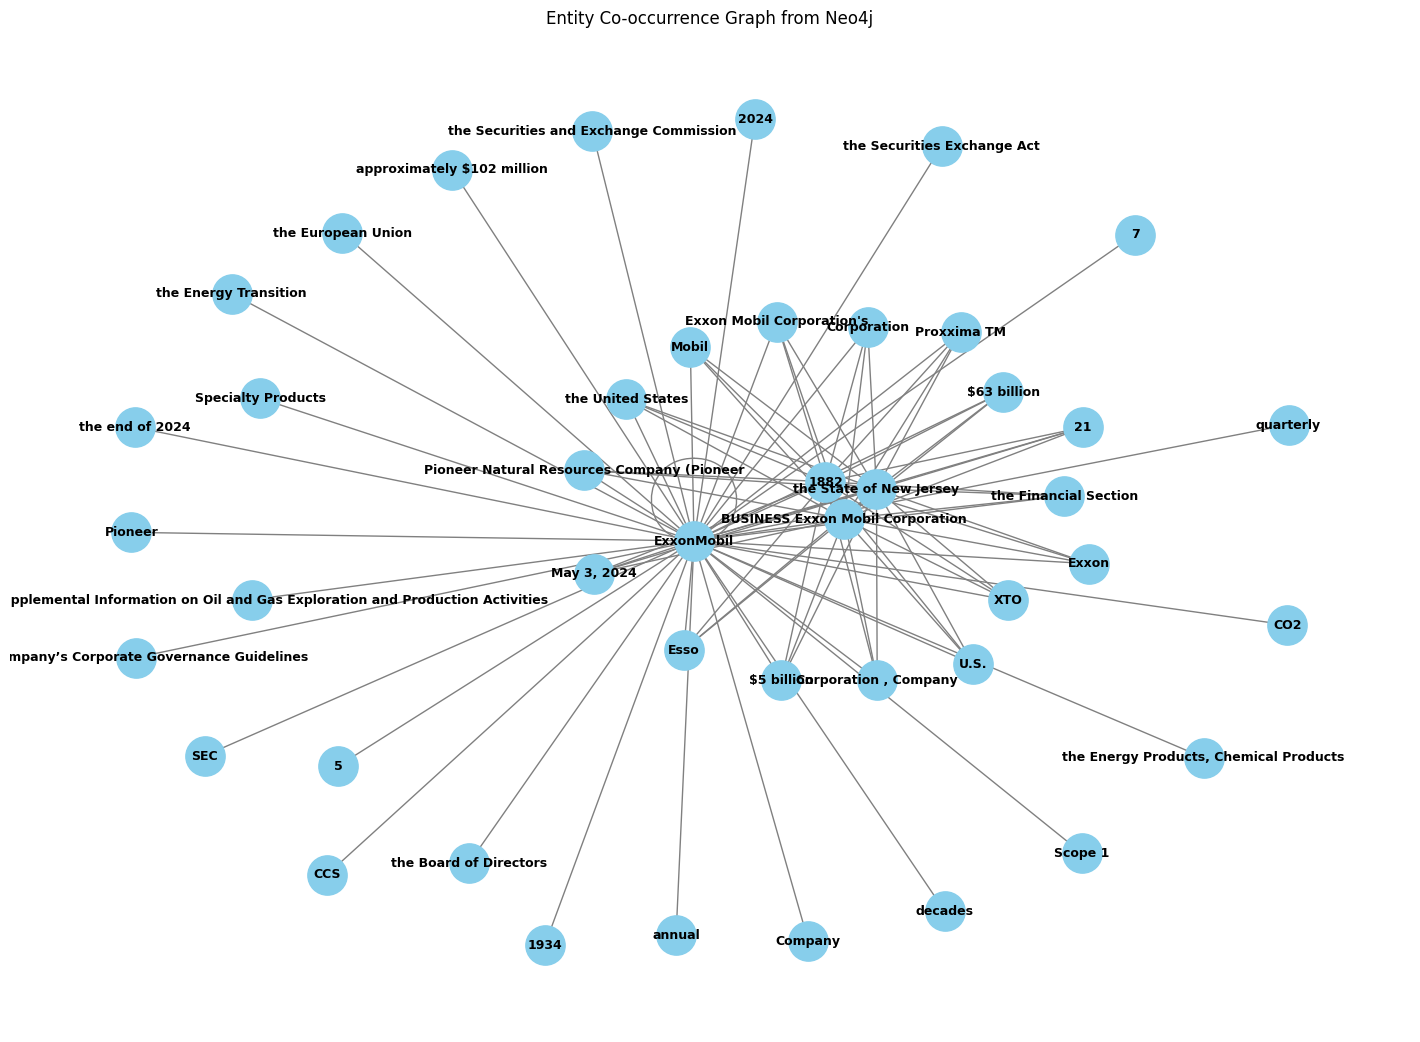

In [ ]:
## In bulks
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

# Step 1: Load environment variables
load_dotenv("rag.env", override=True)
NEO4J_URI = os.getenv("NEO4J_URI")  # e.g., "neo4j://..."
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

# Step 2: Define the Cypher query to fetch entity relationships
cypher_query = """
MATCH (e1:Entity)-[:CO_OCCURS_WITH]-(e2:Entity)
RETURN e1.name AS source, e2.name AS target
LIMIT 200
"""

# Step 3: Connect and query using the official Neo4j driver
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

with driver.session() as session:
    results = session.run(cypher_query)
    edges = [(record["source"], record["target"]) for record in results]

driver.close()

# Step 4: Build NetworkX graph
G = nx.Graph()  # Undirected since CO_OCCURS_WITH is symmetric
G.add_edges_from(edges)

# Step 5: Visualize the graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw(G, pos, with_labels=True, node_size=800, node_color="skyblue", font_size=9, font_weight="bold", edge_color="gray")
plt.title("Entity Co-occurrence Graph from Neo4j")
plt.axis("off")
plt.tight_layout()
plt.show()

## 🧱 Stage 4(1): Batch Graph Construction from 10-K Filings

### 🎯 Objective  
To build a structured **knowledge graph** in Neo4j by automatically processing the **latest 10-K filings** of multiple companies. This includes paragraph-level chunking, entity extraction, relationship creation, and final graph assembly.

---

### ✅ Key Components and What Was Implemented

#### 📂 1. Batch File Loader  
- Mounted `MyDrive/output/` directory from Google Drive.  
- Each company has its own folder containing yearly cleaned 10-K files (e.g., `AAPL_10k_2024.json`, `JPM_10k_2025.json`).  
- Automatically selected the **latest 10-K file** per company using file name patterns and year extraction.

#### ✂️ 2. Chunking with Metadata  
- Parsed key sections (`item1`, `item1a`, `item7`, `item7a`) from JSON.  
- Split into smaller overlapping chunks using `RecursiveCharacterTextSplitter`:
  - `chunk_size=2000`, `chunk_overlap=200`  
- Created `:TextChunk` nodes with metadata:
  - `company`, `year`, `cik`, `cusip6`, `section`, `seq`, `source`, `text`

#### 🧠 3. Named Entity Recognition (NER)  
- Used `spaCy`’s `en_core_web_sm` model for standard entity types:  
  `ORG`, `PRODUCT`, `GPE`, `MONEY`, `PERCENT`, `DATE`, `PERSON`  
- Built `:Entity` nodes and `[:MENTIONS]` relationships to `:TextChunk`.

#### ⚠️ 4. Custom Phrase Matching (Optional Advanced Step)  
- Defined domain-specific risk terms (e.g., `"supply chain disruption"`, `"litigation risk"`).  
- Detected using `PhraseMatcher` and tagged as custom entity type `RISK`.

#### 🔗 5. Co-occurrence Relationship Identification  
- For each paragraph, identified up to 5 distinct entities.  
- For each unordered pair `(e1, e2)`, created/updated `[:CO_OCCURS_WITH]` relationships.  
- Each edge carries:
  - `count` — number of co-mentions  
  - `company` — source company of the relationship

---

### 🧠 Example Graph Schema

- **Nodes:**
  - `(:TextChunk)` — Paragraph-level chunks  
  - `(:Entity)` — Detected entities (ORG, GPE, etc.)

- **Relationships:**
  - `(:TextChunk)-[:MENTIONS]->(:Entity)`  
  - `(:Entity)-[:CO_OCCURS_WITH]-(Entity)`

---

### ✅ Outcome  
Stage 4(1) delivered a **fully populated Neo4j knowledge graph**, capable of supporting entity-based queries and downstream tasks like semantic retrieval and LLM-based reasoning.

> 🚀 This foundation enables the semantic question-answering pipeline in Stage 4(2).